In [18]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 연구용 딥 에이전트

## 개요 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

이제 배운 모든 것을 하나로 모을 수 있습니다:

* **TODO**를 사용하여 작업을 추적합니다. 
* 원시 도구 호출 결과를 저장하기 위해 **파일**을 사용합니다. 
* 컨텍스트 격리를 위해 **연구 작업을 하위 에이전트에게 위임**합니다. 

## 검색 도구 

원시 콘텐츠를 파일로 오프로드하고 요약만 에이전트에 반환하는 검색 도구를 구축할 것입니다. 이는 장기 실행 에이전트 궤적의 일반적인 패턴입니다. [Manus에서 보았듯이](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### 핵심 구성 요소

1. **검색 실행 (`run_tavily_search`)**: 결과 수 및 주제 필터링을 위한 구성 가능한 매개변수를 사용하여 Tavily API를 통해 실제 웹 검색을 수행합니다.

2. **콘텐츠 요약 (`summarize_webpage_content`)**: 경량 모델(GPT-4o-mini)을 사용하여 웹페이지 콘텐츠의 구조화된 요약을 생성하여 설명적인 파일 이름과 주요 학습 요약을 모두 생성합니다.

3. **결과 처리 (`process_search_results`)**: HTTP를 통해 전체 웹페이지 콘텐츠를 가져오고, `markdownify`를 사용하여 HTML을 마크다운으로 변환하고, 각 결과에 대한 요약을 생성합니다.

4. **컨텍스트 오프로드 (`tavily_search` 도구)**: 다음을 수행하는 기본 도구:
   - 검색을 실행하고 결과를 처리합니다.
   - 에이전트 상태의 파일에 전체 콘텐츠를 저장합니다(컨텍스트 오프로드).
   - 에이전트에 최소한의 요약만 반환합니다(컨텍스트 스팸 방지).
   - LangGraph `Command`를 사용하여 파일과 메시지를 모두 업데이트합니다.

5. **전략적 사고 (`think_tool`)**: 에이전트가 연구 결과를 분석하고, 격차를 평가하고, 연구 워크플로우의 다음 단계를 계획할 수 있는 구조화된 반영 메커니즘을 제공합니다.

이 아키텍처는 상세한 검색 결과를 파일에 저장하고 에이전트의 작업 컨텍스트를 최소화하고 집중하여 토큰 효율성 문제를 해결합니다.

In [19]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""연구 도구 모음입니다.

이 모듈은 연구 에이전트를 위한 검색 및 콘텐츠 처리 유틸리티를 제공합니다.
웹 검색 기능과 콘텐츠 요약 도구 등이 포함되어 있습니다.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# 📝 웹페이지 내용을 요약하는 데 사용할 모델을 설정합니다.
# 여기서는 가볍고 빠른 모델을 사용하여 비용과 속도를 최적화해요!
summarization_model = init_chat_model(model="google_genai:gemini-2.5-flash")
# 🔍 Tavily API 클라이언트를 초기화합니다. AI 에이전트를 위한 똑똑한 검색 엔진이죠.
tavily_client = TavilyClient()

class Summary(BaseModel):
	"""웹페이지 콘텐츠 요약을 위한 스키마입니다."""
	filename: str = Field(description="저장할 파일의 이름입니다.")
	summary: str = Field(description="웹페이지의 핵심 학습 내용입니다.")

def get_today_str() -> str:
	"""사람이 읽기 쉬운 형식으로 현재 날짜를 가져옵니다."""
	return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
	search_query: str, 
	max_results: int = 1, 
	topic: Literal["general", "news", "finance"] = "general", 
	include_raw_content: bool = True, 
) -> dict:
	"""단일 쿼리에 대해 Tavily API를 사용하여 검색을 수행합니다.

	Args:
		search_query: 실행할 검색 쿼리입니다.
		max_results: 쿼리당 최대 결과 수입니다.
		topic: 검색 결과에 대한 주제 필터입니다.
		include_raw_content: 원시 웹페이지 콘텐츠 포함 여부입니다.

	Returns:
		검색 결과 딕셔너리를 반환합니다.
	"""
	# 🕵️‍♂️ Tavily 검색을 실행하여 웹에서 정보를 찾아옵니다.
	result = tavily_client.search(
		search_query,
		max_results=max_results,
		include_raw_content=include_raw_content,
		topic=topic
	)

	return result

def summarize_webpage_content(webpage_content: str) -> Summary:
	"""구성된 요약 모델을 사용하여 웹페이지 콘텐츠를 요약합니다.
	
	Args:
		webpage_content: 요약할 원시 웹페이지 콘텐츠입니다.
		
	Returns:
		파일명과 요약이 포함된 Summary 객체를 반환합니다.
	"""
	try:
		# ✨ 요약을 위해 구조화된 출력 모델을 설정합니다. 이렇게 하면 항상 일관된 형식의 결과를 얻을 수 있어요.
		structured_model = summarization_model.with_structured_output(Summary)
		
		# 🤖 요약을 생성합니다. 프롬프트에 오늘 날짜 정보도 함께 넣어주어 최신성을 더합니다.
		summary_and_filename = structured_model.invoke([
			HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
				webpage_content=webpage_content, 
				date=get_today_str()
			))
		])
		
		return summary_and_filename
		
	except Exception:
		# 🚨 만약 요약 과정에서 오류가 발생하면, 기본적인 요약 객체를 대신 반환하여 시스템이 멈추지 않도록 합니다.
		return Summary(
			filename="search_result.md",
			summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
		)

def process_search_results(results: dict) -> list[dict]:
	"""사용 가능한 경우 콘텐츠를 요약하여 검색 결과를 처리합니다.
	
	Args:
		results: Tavily 검색 결과 딕셔너리입니다.
		
	Returns:
		요약이 포함된 처리된 결과 목록을 반환합니다.
	"""
	processed_results = []

	# 🌐 HTTP 요청을 위한 클라이언트를 생성합니다.
	HTTPX_CLIENT = httpx.Client()
	
	for result in results.get('results', []):
		
		# 🔗 결과에서 URL을 가져옵니다.
		url = result['url']
		
		# 📥 URL의 내용을 읽어옵니다.
		response = HTTPX_CLIENT.get(url)

		if response.status_code == 200:
			# ✅ 성공적으로 페이지를 읽었다면, HTML을 마크다운으로 변환하고 내용을 요약합니다.
			raw_content = markdownify(response.text)
			summary_obj = summarize_webpage_content(raw_content)
		else:
			# ❌ URL을 읽는데 실패했다면, Tavily가 제공하는 기본 요약을 사용합니다.
			raw_content = result.get('raw_content', '')
			summary_obj = Summary(
				filename="URL_error.md",
				summary=result.get('content', 'URL을 읽는 중 오류 발생; 다른 검색을 시도해보세요.')
			)
		
		# 📛 파일 이름이 겹치지 않도록 고유한 ID를 생성하여 붙여줍니다.
		uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
		name, ext = os.path.splitext(summary_obj.filename)
		summary_obj.filename = f"{name}_{uid}{ext}"

		processed_results.append({
			'url': result['url'],
			'title': result['title'],
			'summary': summary_obj.summary,
			'filename': summary_obj.filename,
			'raw_content': raw_content,
		})
	
	return processed_results

@tool(parse_docstring=True)
def tavily_search(
	query: str,
	state: Annotated[DeepAgentState, InjectedState],
	tool_call_id: Annotated[str, InjectedToolCallId],
	max_results: Annotated[int, InjectedToolArg] = 1,
	topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
	"""최소한의 컨텍스트를 반환하면서 상세한 결과를 파일에 저장하고 웹을 검색합니다.

	웹 검색을 수행하고 전체 콘텐츠를 파일에 저장하여 컨텍스트를 오프로드합니다.
	에이전트가 다음 단계를 결정하는 데 도움이 되는 필수 정보만 반환합니다.

	Args:
		query: 실행할 검색 쿼리입니다.
		state: 파일 저장을 위한 주입된 에이전트 상태입니다.
		tool_call_id: 주입된 도구 호출 식별자입니다.
		max_results: 반환할 최대 결과 수 (기본값: 1) 입니다.
		topic: 주제 필터 - 'general', 'news', 또는 'finance' (기본값: 'general') 입니다.

	Returns:
		전체 결과를 파일에 저장하고 최소한의 요약을 제공하는 Command를 반환합니다.
	"""
	# 🚀 검색을 실행합니다.
	search_results = run_tavily_search(
		query,
		max_results=max_results,
		topic=topic,
		include_raw_content=True,
	) 

	# 🔄 결과를 처리하고 요약합니다.
	processed_results = process_search_results(search_results)
	
	# 💾 각 결과를 파일에 저장하고 요약을 준비합니다.
	files = state.get("files", {})
	saved_files = []
	summaries = []
	
	for i, result in enumerate(processed_results):
		# AI가 생성한 파일 이름을 사용합니다.
		filename = result['filename']
		
		# 📄 전체 세부 정보가 포함된 파일 콘텐츠를 생성합니다.
		file_content = f"""# 검색 결과: {result['title']}

**URL:** {result['url']}
**쿼리:** {query}
**날짜:** {get_today_str()}

## 요약
{result['summary']}

## 원본 콘텐츠
{result['raw_content'] if result['raw_content'] else '사용 가능한 원본 콘텐츠 없음'}
"""
		
		files[filename] = file_content
		saved_files.append(filename)
		summaries.append(f"- {filename}: {result['summary']}...")
	
	# 📝 도구 메시지를 위한 최소한의 요약을 생성합니다. 무엇을 수집했는지에 초점을 맞춥니다.
	summary_text = f"""🔍 '{query}'에 대한 {len(processed_results)}개의 결과를 찾았습니다:

{chr(10).join(summaries)}

파일: {', '.join(saved_files)}
💡 필요할 때 `read_file()`을 사용하여 전체 세부 정보에 액세스하세요."""

	return Command(
		update={
			"files": files,
			"messages": [
				ToolMessage(summary_text, tool_call_id=tool_call_id)
			],
		}
	)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
	"""연구 진행 상황 및 의사 결정에 대한 전략적 성찰을 위한 도구입니다.

	각 검색 후에 이 도구를 사용하여 결과를 분석하고 다음 단계를 체계적으로 계획하세요.
	이는 양질의 의사 결정을 위해 연구 워크플로우에 의도적인 멈춤을 만듭니다.

	사용 시기:
	- 검색 결과를 받은 후: 어떤 핵심 정보를 찾았는가?
	- 다음 단계를 결정하기 전: 포괄적으로 답변하기에 충분한 정보가 있는가?
	- 연구 격차를 평가할 때: 구체적으로 어떤 정보가 아직 부족한가?
	- 연구를 마치기 전: 이제 완전한 답변을 제공할 수 있는가?
	- 질문이 얼마나 복잡한가: 검색 제한 횟수에 도달했는가?

	성찰은 다음을 다루어야 합니다:
	1. 현재 결과 분석 - 어떤 구체적인 정보를 수집했는가?
	2. 격차 평가 - 어떤 중요한 정보가 여전히 부족한가?
	3. 품질 평가 - 좋은 답변을 위한 충분한 증거나 예시가 있는가?
	4. 전략적 결정 - 검색을 계속해야 하는가, 아니면 답변을 제공해야 하는가?

	Args:
		reflection: 연구 진행 상황, 결과, 격차 및 다음 단계에 대한 상세한 성찰입니다.

	Returns:
		의사 결정을 위해 성찰이 기록되었다는 확인 메시지를 반환합니다.
	"""
	return f"성찰 기록됨: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## 딥 에이전트

이제 이전 학습 내용을 모두 적용할 수 있습니다: 

* 연구원에게 `think_tool`과 위에 있는 `search_tool`을 제공할 것입니다.
* 부모 에이전트 파일 도구, `think_tool`, `task` 도구를 제공할 것입니다. 

In [20]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt, stream_agent

# 📂 파일 시스템, 프롬프트, 도구 등 에이전트에 필요한 모든 구성 요소를 가져옵니다.
# 우리가 이전에 만들었던 기능들을 여기서 모두 조립한다고 생각하시면 돼요!
from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
	FILE_USAGE_INSTRUCTIONS,
	RESEARCHER_INSTRUCTIONS,
	SUBAGENT_USAGE_INSTRUCTIONS,
	TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos

# 🤖 `create_react_agent`를 사용하여 직접 에이전트를 생성합니다.
# 사용할 모델과 온도를 설정합니다. 온도가 0이면 가장 결정적인 답변을 생성해요.
model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)

# 🚦 에이전트의 행동을 제어하기 위한 한계를 설정합니다.
# 동시에 실행할 수 있는 최대 연구 단위와, 연구 에이전트의 최대 반복 횟수를 정해줘요.
max_concurrent_research_units = 3
max_researcher_iterations = 3

# 🛠️ 에이전트가 사용할 도구들을 종류별로 정리합니다.
# 하위 에이전트용 도구, 기본 내장 도구 등을 명확히 구분하면 관리하기 편해요.
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# 🕵️‍♂️ 연구를 전문으로 하는 하위 에이전트를 정의합니다.
# 이름, 설명, 프롬프트, 그리고 사용할 도구를 지정해서 역할을 명확하게 부여해요.
research_sub_agent = {
	"name": "research-agent",
	"description": "하위 에이전트 연구원에게 연구를 위임합니다. 이 연구원에게는 한 번에 하나의 주제만 주세요.",
	"prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
	"tools": ["tavily_search", "think_tool"],
}

# ✨ 작업을 하위 에이전트에게 위임할 수 있는 'task' 도구를 생성합니다.
# 이 도구가 바로 메인 에이전트와 하위 에이전트를 연결하는 핵심적인 다리 역할을 합니다.
task_tool = _create_task_tool(
	sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# 🤝 위임 도구를 목록에 추가하고, 모든 도구를 하나로 합칩니다.
# 메인 에이전트는 이 'all_tools' 목록에 있는 모든 도구를 사용할 수 있게 됩니다.
delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # 간단한 경우에는 메인 에이전트도 검색을 사용할 수 있도록 합니다.

# 📝 에이전트에게 전달할 최종 프롬프트(사용 설명서)를 만듭니다.
# 여기에는 하위 에이전트 사용법에 대한 지침이 포함됩니다.
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
	max_concurrent_research_units=max_concurrent_research_units,
	max_researcher_iterations=max_researcher_iterations,
	date=datetime.now().strftime("%a %b %-d, %Y"),
)

E0000 00:00:1760678598.752442  540781 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [21]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [22]:
# 📜 에이전트를 위한 최종 지침서를 만듭니다.
# 지금까지 정의한 모든 규칙과 사용법을 하나로 합쳐서
# 에이전트가 자신의 역할과 능력을 명확히 인지하도록 돕습니다.
INSTRUCTIONS = (
	"# ✅ TODO 관리 지침\n"
	+ TODO_USAGE_INSTRUCTIONS
	+ "\n\n"
	+ "=" * 80
	+ "\n\n"
	+ "# 🗂️ 파일 시스템 사용 지침\n"
	+ FILE_USAGE_INSTRUCTIONS
	+ "\n\n"
	+ "=" * 80
	+ "\n\n"
	+ "# 🧑‍🤝‍🧑 하위 에이전트 위임 지침\n"
	+ SUBAGENT_INSTRUCTIONS
)

# 👨‍🏫 완성된 지침서의 내용을 한번 살펴볼까요?
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # ✅ TODO 관리 지침                                                                                            │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # 🗂️ 파일 시스템 사용 지침                                                                                      │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # 🧑‍🤝‍🧑 하위 에이전트 위임 지침                                                                               │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                                                       

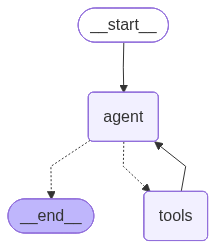

In [23]:
# ✨ 드디어 최종 에이전트를 생성합니다!
# 지금까지 준비한 모델, 모든 도구들, 그리고 상세한 지침서를 `create_react_agent`에 전달하여
# 우리의 똑똑한 '딥 에이전트'를 만듭니다.
agent = create_react_agent(
	model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# 📊 생성된 에이전트의 아키텍처를 다이어그램으로 시각화하여 확인해봅시다.
# 에이전트가 어떤 흐름으로 생각하고 행동하는지 한눈에 파악할 수 있어요.
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [24]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Research Model Context Protocol (MCP)"                                                        │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Provide an overview of MCP"                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: d8aa163c-32ed-451d-b6d7-3cfc15f36a06                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP)', 'status': 'pending'}, {'content':    │
│ 'Provide an overview of MCP', 'status': 'pending'}]                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research Model Context Protocol (MCP) to understand its purpose, key features, and how it     │
│ works."                                                                                                         │
│ }                                                                                                               │
│    ID: ec69e8f1-4ae6-45e1-b422-d1751cffa08c                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open-source protocol developed by Anthropic. Its primary purpose is to   │
│ standardize how large language models (LLMs) connect with external data sources and tools. This effectively     │
│ addresses the "NxM problem," which refers to the challenge of managing numerous custom integrations between     │
│ LLMs and various external resources.                                                                            │
│                                                                                                                 │
│ Key features of MCP include:                                                                                    │
│ *   **Open-source nature:** This allows for community contributions and widespread adoption.                    │
│ *   **Client-server architecture:** This design facilitates universal tool discovery and execution for AI       │
│ applications.                                                                                                   │
│ *   **Standardization:** It provides a consistent framework for LLMs to interact with diverse external data and │
│ tools.                                                                                                          │
│                                                                                                                 │
│ MCP works by establishing a standardized communication layer between LLMs and external resources. This          │
│ client-server architecture enables LLMs to discover and utilize various tools and data sources without          │
│ requiring custom integrations for each one. While MCP simplifies development and enhances the capabilities of   │
│ AI applications, its rapid adoption has exposed significant security vulnerabilities. Many MCP servers          │
│ currently lack proper authentication and permissioning, highlighting a critical need for robust authorization   │
│ and human-in-the-loop design to prevent misuse and data breaches.                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: 94561951-e20f-454e-a91f-b1c9ffb4e0bc                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Research Model Context Protocol (MCP) (pending)                                                           │
│ 2. ⏳ Provide an overview of MCP (pending)                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Research Model Context Protocol (MCP)"                                                        │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Provide an overview of MCP"                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 52a80bbd-f679-4cc6-b62e-5d19fe46b67c                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP)', 'status': 'completed'}, {'content':  │
│ 'Provide an overview of MCP', 'status': 'pending'}]                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I have successfully researched the Model Context Protocol (MCP). I now have a good             │
│ understanding of its purpose, key features, and how it works, as well as its security implications. I can now   │
│ provide an overview of MCP."                                                                                    │
│ }                                                                                                               │
│    ID: 28f6c484-dcd5-4aef-b5ef-1437ead47042                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 성찰 기록됨: I have successfully researched the Model Context Protocol (MCP). I now have a good understanding   │
│ of its purpose, key features, and how it works, as well as its security implications. I can now provide an      │
│ overview of MCP.                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Model Context Protocol (MCP) is an open-source protocol developed by Anthropic. Its main goal is to standardize │
│ how large language models (LLMs) connect with external data sources and tools, effectively solving the "NxM     │
│ problem" of managing numerous custom integrations.                                                              │
│                                                                                                                 │
│ Key features of MCP include:                                                                                    │
│                                                                                                                 │
│ *   **Open-source:** This allows for community contributions and widespread adoption.                           │
│ *   **Client-server architecture:** This design facilitates universal tool discovery and execution for AI       │
│ applications.                                                                                                   │
│ *   **Standardization:** It provides a consistent framework for LLMs to interact with diverse external data and │
│ tools.                                                                                                          │
│                                                                                                                 │
│ MCP works by establishing a standardized communication layer between LLMs and external resources. This          │
│ client-server architecture enables LLMs to discover and utilize various tools and data sources without          │
│ requiring custom integrations for each one. While MCP simplifies development and enhances the capabilities of   │
│ AI applications, its rapid adoption has exposed significant security vulnerabilities. Many MCP servers          │
│ currently lack proper authentication and permissioning, highlighting a critical need for robust authorization   │
│ and human-in-the-loop design to prevent misuse and data breaches.                                               │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Research Model Context Protocol (MCP)"                                                        │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Provide an overview of MCP"                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 18185460-6040-4ded-8d19-fcfdb5d61d18                                                                     │
╰─────────────────────────────────────────────────────────

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP)', 'status': 'completed'}, {'content':  │
│ 'Provide an overview of MCP', 'status': 'completed'}]                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open-source protocol developed by Anthropic. Its main goal is to         │
│ standardize how large language models (LLMs) interact with external data sources and tools, effectively solving │
│ the "NxM problem" of managing numerous custom integrations.                                                     │
│                                                                                                                 │
│ Key aspects of MCP include:                                                                                     │
│                                                                                                                 │
│ *   **Open-source:** This allows for community collaboration and widespread adoption.                           │
│ *   **Client-server architecture:** This design enables LLMs to discover and execute tools universally within   │
│ AI applications.                                                                                                │
│ *   **Standardization:** It provides a consistent framework for LLMs to connect with various external data and  │
│ tools without needing custom integrations for each.                                                             │
│                                                                                                                 │
│ While MCP simplifies development and enhances AI application capabilities, its rapid adoption has also exposed  │
│ significant security vulnerabilities. Many MCP servers currently lack proper authentication and permissioning,  │
│ highlighting a critical need for robust authorization and human-in-the-loop design to prevent misuse and data   │
│ breaches.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## 딥 에이전트 패키지 사용

이제 기본 패턴을 이해하셨습니다! 

[ `deepagents` 패키지](https://github.com/hwchase17/deepagents)를 간단한 추상화로 사용할 수 있습니다:

* 파일 시스템 도구가 포함되어 있습니다.
* todo 도구가 포함되어 있습니다.
* 작업 도구가 포함되어 있습니다.

하위 에이전트와 하위 에이전트가 사용할 도구만 제공하면 됩니다.

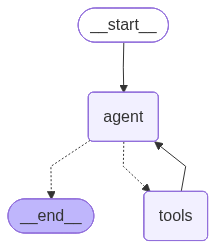

In [25]:
from deepagents import create_deep_agent

# 🎁 `deepagents` 패키지를 사용하여 훨씬 더 간편하게 딥 에이전트를 생성합니다!
# 이 함수는 파일 시스템, TODO, 작업 위임 도구를 자동으로 포함해주기 때문에
# 우리는 하위 에이전트와 그들이 사용할 도구, 그리고 지침만 제공하면 됩니다.
# 훨씬 깔끔하고 편리하죠?
agent = create_deep_agent(
	sub_agent_tools,
	INSTRUCTIONS,
	subagents=[research_sub_agent],
	model=model,
)

# 📊 패키지로 생성한 에이전트의 구조도 한번 살펴볼까요?
# 직접 만들었을 때와 동일한 구조를 가지고 있는지 확인해보세요!
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [26]:
result = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "Give me an very brief overview of Model Context Protocol (MCP).",
			}
		],
	}
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Search for \"Model Context Protocol (MCP)\" to get an overview."                              │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 834eb910-92a0-4b3b-9ed7-d586fce323bb                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for "Model Context Protocol (MCP)" to get an overview.', 'status':    │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Search for \"Model Context Protocol (MCP)\" to get an overview."                              │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 190ddb71-1bed-44f1-af0a-adfbd5eb30bb                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for "Model Context Protocol (MCP)" to get an overview.', 'status':    │
│ 'in_progress'}]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Provide a very brief overview of Model Context Protocol (MCP)."                               │
│ }                                                                                                               │
│    ID: d8a3c9c6-bd65-4f4a-9c03-affbfe1b3813                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is a standardization layer designed to enable AI applications to effectively   │
│ communicate with external services such as tools and databases. It streamlines tool integration for AI agents,  │
│ enhances context-awareness, and helps prevent issues in multi-agent systems. Essentially, MCP acts as a         │
│ standardized connector for tools, complementing existing agent orchestration frameworks by facilitating         │
│ efficient, relevant, and structured context use for optimal AI model performance.                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Search for \"Model Context Protocol (MCP)\" to get an overview."                              │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: e1718ccf-fda5-467c-a0ea-a8a2d9768477                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for "Model Context Protocol (MCP)" to get an overview.', 'status':    │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is a standardization layer that allows AI applications to communicate          │
│ effectively with external services like tools and databases. It simplifies tool integration for AI agents,      │
│ improves context awareness, and helps prevent problems in multi-agent systems. In essence, MCP serves as a      │
│ standardized connector for tools, working alongside existing agent orchestration frameworks to ensure AI models │
│ use context efficiently, relevantly, and in a structured manner for optimal performance.                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->